<a href="https://colab.research.google.com/github/StephenSheng1101/DMAsgmnt/blob/main/Ridge%20Regression%20Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ridge Regression**


**Data Preprocessing before begin with Ridge Regression**

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
df = pd.read_csv("dataset.csv")
transport = pd.read_csv("dataset.csv")
transport.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,2013-07-02 19:54:00.000000232,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,2013-09-28 00:21:31.0000002,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,2013-06-16 03:18:00.000000150,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,2013-07-20 13:43:00.000000121,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,2013-11-05 22:57:17.0000003,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [3]:
transport.describe()
transport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107832 entries, 0 to 1107831
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   ID              1107832 non-null  object 
 1   travel_fee      1107832 non-null  float64
 2   departure_time  1107832 non-null  object 
 3   departure_long  1107832 non-null  float64
 4   departure_lat   1107832 non-null  float64
 5   arrival_long    1107816 non-null  float64
 6   arrival_lat     1107816 non-null  float64
 7   occupancy       1107831 non-null  float64
dtypes: float64(6), object(2)
memory usage: 67.6+ MB


In [4]:
transport.isnull().sum()

ID                 0
travel_fee         0
departure_time     0
departure_long     0
departure_lat      0
arrival_long      16
arrival_lat       16
occupancy          1
dtype: int64

In [5]:
#handling missing value
transport["departure_long"].fillna(transport["departure_long"].mean(), inplace=True)
transport["departure_lat"].fillna(transport["departure_lat"].mean(), inplace=True)
transport["occupancy"].fillna(transport["occupancy"].mode()[0], inplace=True)
transport.drop(columns=['ID'], inplace=True)

# Drop rows with missing "departure_time","arrival_long" and "arrival_lat"
transport.dropna(subset=["departure_time", "arrival_long", "arrival_lat"],inplace = True)
transport.isnull().sum()

# Drop rows with a 0 value of occupancy
transport = transport.drop(transport[transport['occupancy'] <= 0].index)

In [6]:
transport.head()

,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1.0
1,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1.0
2,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1.0
3,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5.0
4,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2.0


In [7]:
# Convert departure_time to datetime
transport['departure_time'] = pd.to_datetime(transport['departure_time'])

# Extract features from departure_time
transport['hour_of_day'] = transport['departure_time'].dt.hour
transport['day_of_week'] = transport['departure_time'].dt.dayofweek

In [8]:
from sklearn.preprocessing import StandardScaler

data_numeric = transport.drop(columns=['departure_time'])

# Perform feature scaling using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_numeric)
scaled_data

array([[-0.51734524, -0.13924533,  0.11344532, ..., -0.51578049,
         0.83893762, -1.0420532 ],
       [-0.655991  , -0.14003076,  0.11113543, ..., -0.51578049,
        -2.0644577 ,  1.00297038],
       [ 0.82289705, -0.13797107,  0.11709517, ..., -0.51578049,
        -1.60602686,  1.51422628],
       ...,
       [ 1.87013464, -0.13572183,  0.11730383, ...,  3.11947592,
         0.53331706, -1.0420532 ],
       [-0.37869949, -0.13716619,  0.11477856, ..., -0.51578049,
         0.38050678,  1.00297038],
       [ 0.36074453, -0.13775092,  0.11530137, ..., -0.51578049,
         0.83893762, -0.01954141]])

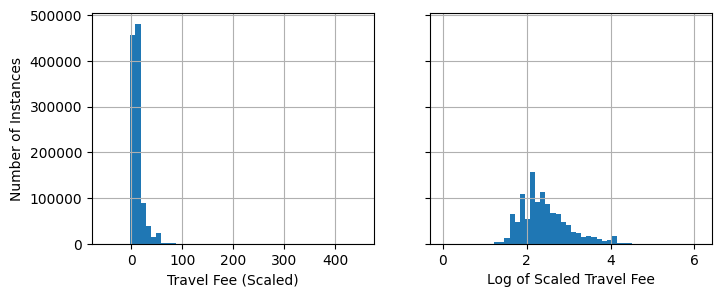

In [9]:
# Plot histogram of a scaled feature
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
transport["travel_fee"].hist(ax=axs[0], bins=50)
transport["travel_fee"].apply(np.log1p).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Travel Fee (Scaled)")
axs[1].set_xlabel("Log of Scaled Travel Fee")
axs[0].set_ylabel("Number of Instances")
plt.show()

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

num_attribs = ['travel_fee', 'departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'hour_of_day', 'day_of_week','occupancy']

num_pipeline = make_pipeline(
    StandardScaler()  # Scale features
)
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    # Apply numeric pipeline to numeric attributes
])

In [11]:
transport_prepared = preprocessing.fit_transform(transport)
transport_prepared

array([[-0.51734524, -0.13924533,  0.11344532, ...,  0.83893762,
        -1.0420532 , -0.51578049],
       [-0.655991  , -0.14003076,  0.11113543, ..., -2.0644577 ,
         1.00297038, -0.51578049],
       [ 0.82289705, -0.13797107,  0.11709517, ..., -1.60602686,
         1.51422628, -0.51578049],
       ...,
       [ 1.87013464, -0.13572183,  0.11730383, ...,  0.53331706,
        -1.0420532 ,  3.11947592],
       [-0.37869949, -0.13716619,  0.11477856, ...,  0.38050678,
         1.00297038, -0.51578049],
       [ 0.36074453, -0.13775092,  0.11530137, ...,  0.83893762,
        -0.01954141, -0.51578049]])

**Select and Train a Model on the Prepared Training Set**

**Ridge Regression**

Ridge Regression is a regularization technique used to prevent overfitting in linear regression models by adding a penalty term to the cost function based on the L2 norm of the coefficients. Let's continue with implementing Ridge Regression the preprocessed data.

In [12]:
#Imported necessary libraries and modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics.pairwise import euclidean_distances

In [13]:
# Define features (X) and target variable (y)
X = transport_prepared[:, 1:]  # Exclude the 'travel_fee' column
y = transport_prepared[:, 0]   # Use the 'travel_fee' column as the target variable


In [14]:
# Define different alpha values
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [15]:
# Create an empty dictionary to store RMSE scores for each alpha
rmse_scores_dict = {}

In [16]:
# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
# Iterate through each alpha value
for alpha in alphas:
    # Create a Ridge Regression model with the current alpha
    model = Ridge(alpha=alpha)

    # Perform K-fold cross-validation
    rmse_scores = np.sqrt(-cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error'))

    # Store the RMSE scores in the dictionary
    rmse_scores_dict[alpha] = rmse_scores

In [18]:
# Convert the dictionary into a DataFrame for easier analysis
rmse_df = pd.DataFrame(rmse_scores_dict)

In [19]:
# Calculate the mean RMSE and standard deviation for each alpha
rmse_mean = rmse_df.mean()
rmse_std = rmse_df.std()

In [20]:
# Find the alpha with the lowest mean RMSE
best_alpha = rmse_mean.idxmin()

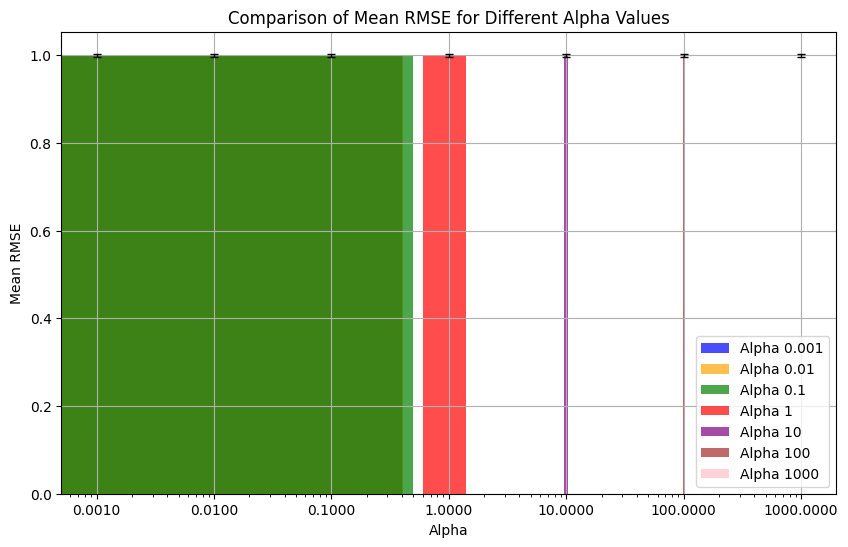

Mean RMSE for each alpha:
0.0010000000: 0.9997097569
0.0100000000: 0.9997097560
0.1000000000: 0.9997097470
1.0000000000: 0.9997096569
10.0000000000: 0.9997087614
100.0000000000: 0.9997002586
1000.0000000000: 0.9996449836

Standard Deviation of RMSE for each alpha:
0.0010000000: 0.0033220839
0.0100000000: 0.0033220840
0.1000000000: 0.0033220853
1.0000000000: 0.0033220982
10.0000000000: 0.0033222275
100.0000000000: 0.0033235212
1000.0000000000: 0.0033350066

Best alpha: 1000.0


In [21]:
# Define colors for each bar
bar_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

# Visualize the comparison between each alpha outcome using a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(alphas, rmse_mean, yerr=rmse_std, align='center', capsize=5, color=bar_colors, alpha=0.7, error_kw={'elinewidth': 1, 'capsize': 3})
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('Alpha')
plt.ylabel('Mean RMSE')
plt.title('Comparison of Mean RMSE for Different Alpha Values')
plt.xticks(alphas, ['{:.4f}'.format(a) for a in alphas])  # Set x-axis ticks to the specified alpha values
plt.grid(True)
plt.legend(bars, ['Alpha ' + str(a) for a in alphas])  # Add legend
plt.show()

print("Mean RMSE for each alpha:")
for alpha, mean_rmse in zip(alphas, rmse_mean):
    print("{:.10f}: {:.10f}".format(alpha, mean_rmse))

print("\nStandard Deviation of RMSE for each alpha:")
for alpha, std_rmse in zip(alphas, rmse_std):
    print("{:.10f}: {:.10f}".format(alpha, std_rmse))

print("\nBest alpha:", best_alpha)

# Fine-tune Ridge Regression model (shortlisted promising models) using crossvalidation.


In [22]:
from sklearn.model_selection import GridSearchCV

# Define the alpha values to search through
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Create a Ridge Regression model
ridge_model = Ridge()

# Initialize GridSearchCV with Ridge model and parameter grid
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform the grid search on the data
grid_search.fit(X, y)

# Get the best alpha value and associated RMSE score
best_alpha = grid_search.best_params_['alpha']
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best alpha:", best_alpha)
print("Best RMSE:", best_rmse)

Best alpha: 1000
Best RMSE: 0.9996699779655477
